# Resources:

### OpenCV Method Documentation
Here I have tried listing the modules in the order I use them through out the notebook 
* [medianBlur](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9)
* [adaptiveThreshold](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#ga72b913f352e4a1b1b397736707afcde3)
* [Canny](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de)
* [Dilate](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga4ff0f3318642c4f469d0e11f242f3b6c)
* [approxPolyDP](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c)
* [arcLength](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga8d26483c636be6b35c3ec6335798a47c)
* [contourArea](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1)
* [findContours](https://docs.opencv.org/4.5.4/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0)
* [drawContours](https://docs.opencv.org/4.5.4/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc)
* [isContourConvex](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga8abf8010377b58cbc16db6734d92941b)
* [getPerspectiveTransform](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae)
* [warpPerspective](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87)

### Online Resources 
* [Contours and Convexity](https://medium.com/analytics-vidhya/contours-and-convex-hull-in-opencv-python-d7503f6651bc) 
* [Android Rectangle Solution](https://stackoverflow.com/questions/8667818/opencv-c-obj-c-detecting-a-sheet-of-paper-square-detection)

# Description

This notebook details the steps we use to preprocess an image. We begin by blurring the image before applying the Canny edge detector. Once the edges have been detected, we perform dilation on these edges in order to fill in any missing holes or break segments in the lines.

From our remaining edges, we detect those that form a contour (the line connects back to itself). From these contours, we calculate their area and eliminate those whose area takes up roughly 98-100% of the image (because it might be that there is a border around the image). After this, we employ the Douglas-Peucker algorithm in order to approximate the next largest contour as a polygon shape (a rectangle in particular). At this point, we hopefully have the border of the Sudoku puzzle. With this rectangular border, we calculate the homographic transformation so that we can get a birds-eye view of the puzzle and so that the puzzle takes up most of the new image. From here, we can simply partition the image evenly into a 9x9 grid and run each cell into a digit classifier.

In [1]:
import cv2
import numpy as np
from numpy import ndarray
from matplotlib import pyplot as plt
from copy import copy
from typing import *

print(f"OpenCV2 version: {cv2.__version__}")

OpenCV2 version: 4.11.0


In [2]:
def resize_image_high_quality(image, target_width: int = 3400, target_height: int = 2500, verbose: bool = False):
    """
    Resize image to target dimensions only if current dimensions are smaller.
    Uses high-quality interpolation methods.

    Args:
        image: Input image (numpy array)
        target_width: Target width (default: 3400)
        target_height: Target height (default: 2500)

    Returns:
        Resized image or original image if already large enough
    """
    current_height, current_width = image.shape[:2]

    # Check if image is already at least the target size
    if current_width >= target_width and current_height >= target_height:
        if verbose: print(f"Image already large enough ({current_width}x{current_height}). No resize needed.")
        return image

    if verbose: print(f"Resizing from {current_width}x{current_height} to {target_width}x{target_height}")

    # Use INTER_CUBIC for high quality upscaling
    # INTER_LANCZOS4 is even higher quality but slower
    resized = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_CUBIC)

    return resized

Here we are simply getting started and displayed the images that we will be using in grayscale. 

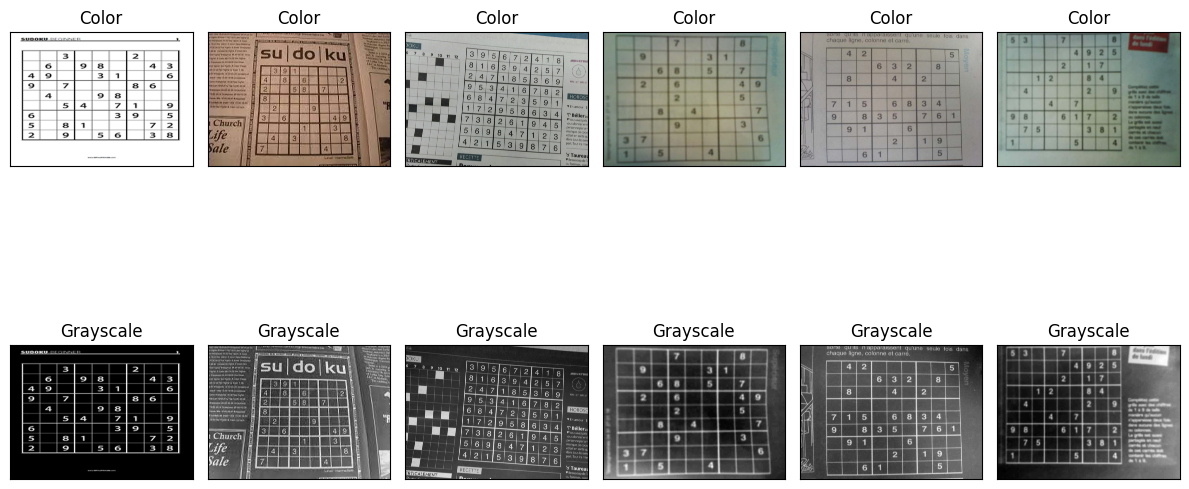

In [3]:
image_paths = ['./sudoku.png', './sudoku_newspaper.jpeg', './sudoku_newspaper2.jpg', './original_dataset/image1.jpg', './original_dataset/image10.jpg', './original_dataset/image100.jpg']

# Load and convert BGR → RGB
images = [resize_image_high_quality((cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB))) for p in image_paths]
# Load grayscale
gray_images = [resize_image_high_quality(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) for p in image_paths]

fig = plt.figure(figsize=(12, 8))
for i, (img, gray_img) in enumerate(zip(images, gray_images)):
    plt.subplot(2, len(image_paths), i + 1)
    plt.imshow(img)
    plt.title("Color")
    plt.xticks([]), plt.yticks([])

    plt.subplot(2, len(image_paths), i + 1 + len(image_paths))
    plt.imshow(gray_img, cmap='gray_r')  # invert grayscale
    plt.title("Grayscale")
    plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()


## Process for Finding Rectangles in the Image
This section will walk step-by-step at image processing is being done and why it is being done. At the end, all the code will be put together into a single function. 

1.) Here we are first applying a median blur to the image. This will help if the image is grainy and can be particulary useful considering that we wish to work with black and white images. 

1.) First we will add contrast to the image

In [4]:
img_options = {
        'contrast': 1.2,
        'brightness': 0.0,
        'blur_radius': 25,
        'canny': (250, 200),
        'kernel': np.ones((11,11), np.uint8),
        'anchor': [-1,1],
        'chosen_contour': 0
    }

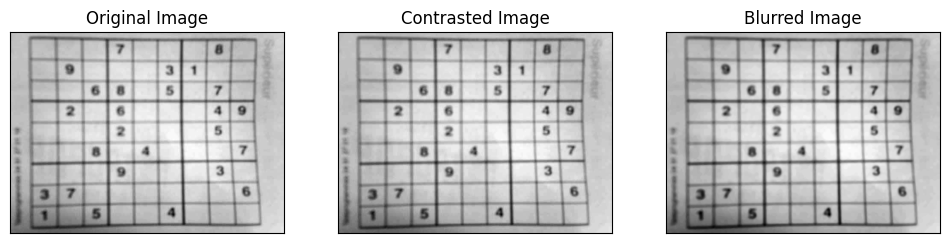

In [5]:
# choose an image to work with
chosen_img = 3
img = gray_images[chosen_img]
contr_img = cv2.addWeighted(img, img_options['contrast'], img, 0, img_options['brightness'])
# contr_img = img
blur_img = cv2.medianBlur(contr_img, img_options['blur_radius'])
# display results
fig = plt.figure(figsize=(12,8))
plt.subplot(1,3,1),plt.imshow(img,'gray')
plt.title('Original Image')
plt.xticks([]),plt.yticks([])
plt.subplot(1,3,2),plt.imshow(contr_img,'gray')
plt.title('Contrasted Image')
plt.xticks([]),plt.yticks([])
plt.subplot(1,3,3),plt.imshow(blur_img,'gray')
plt.title('Blurred Image')
plt.xticks([]),plt.yticks([])
plt.show()

2.) Now we will be applying the Canny edge detector to detect all black lines in the image. 

Shape gray: (2500, 3400), dtype: uint8


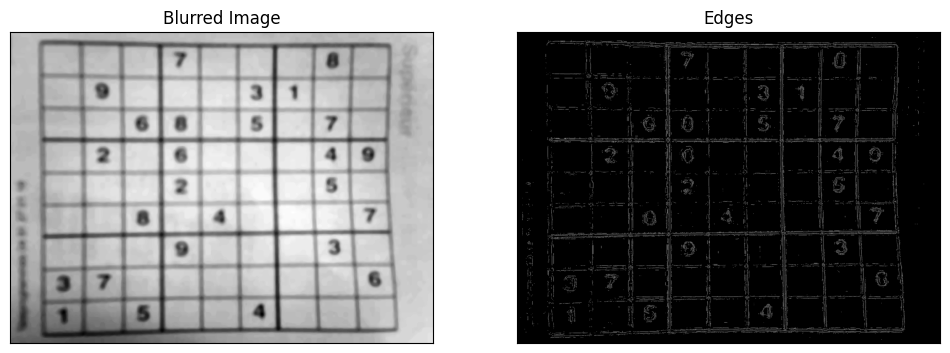

In [6]:
gray = cv2.adaptiveThreshold(blur_img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
gray = cv2.Canny(gray, *img_options['canny'])
print(f"Shape gray: {gray.shape}, dtype: {gray.dtype}")
# display results
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1),plt.imshow(blur_img,'gray')
plt.title('Blurred Image')
plt.xticks([]),plt.yticks([])
plt.subplot(1,2,2),plt.imshow(gray,'gray')
plt.title('Edges')
plt.xticks([]),plt.yticks([])
plt.show()

3.) Next we will apply dilation to fill in any holes in any line segments. 

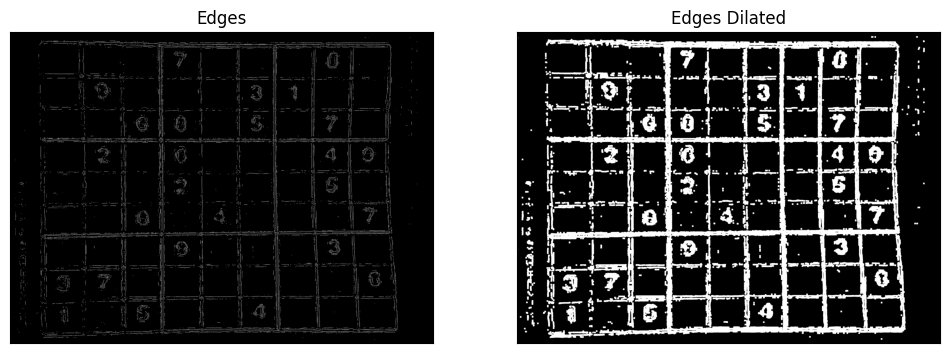

In [7]:
gray_dilate = cv2.dilate(gray, img_options['kernel'], np.zeros(gray.shape, dtype=np.uint8), img_options['anchor'])
# gray_dilate = gray

# display results
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1),plt.imshow(gray,'gray')
plt.title('Edges')
plt.xticks([]),plt.yticks([])
plt.subplot(1,2,2),plt.imshow(gray_dilate,'gray')
plt.title('Edges Dilated')
plt.xticks([]),plt.yticks([])
plt.show()

4.) The next step is to find all the contours in the image. Afterwards, we will display the first four contours. 

Area of largest contour: 4197975.5      
Area of image: 8500000      
Fractional Area: 0.4938794705882353      
Largest Area Index: 392      
Number of Contours: 959


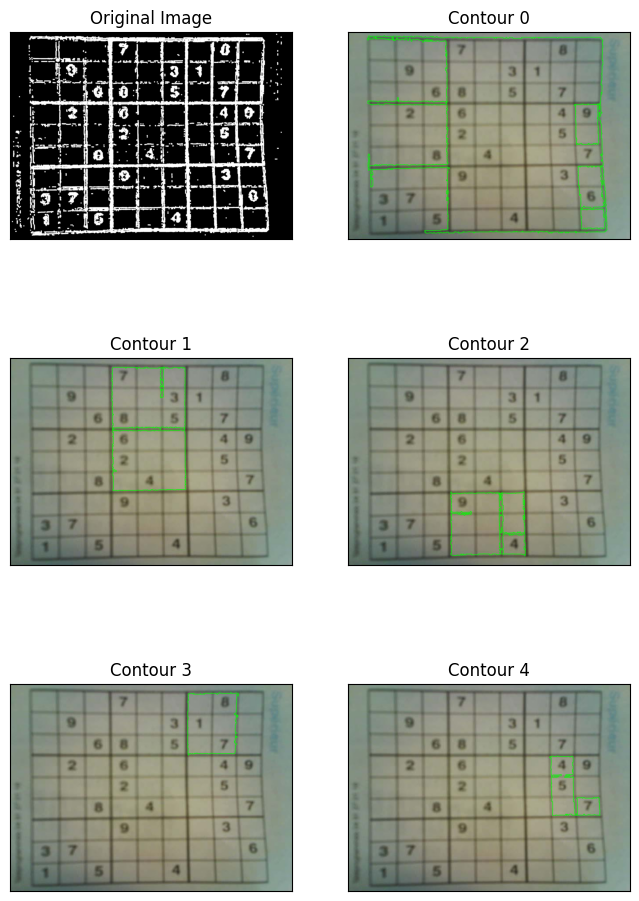

In [8]:
contours, _ = cv2.findContours(gray_dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# display results 
num_contours_display = 5
total_imgs = num_contours_display + 1
rows = total_imgs // 2
results = [gray_dilate]
titles = ['Original Image']

# sort by the largest contour
contour_areas = np.array([cv2.contourArea(cont) for cont in contours])
area_indices = np.flip(np.argsort(contour_areas)) # sort areas in decreasing order

# Just to analyze the area of the largest contour
largest_area = contour_areas[area_indices[0]]
total_area = images[chosen_img].shape[0] * images[chosen_img].shape[1]
print(f"Area of largest contour: {largest_area}\
      \nArea of image: {total_area}\
      \nFractional Area: {largest_area/total_area}\
      \nLargest Area Index: {area_indices[0]}\
      \nNumber of Contours: {len(contour_areas)}")

# filter out contours whose area is nearly the entire image
# which would indicate that there is a border around the image
l_i = 0
area_threshold = 0.98 # if contour area is 98% of the image or greater, ignore
for i, area_idx in enumerate(area_indices):
    curr_area = contour_areas[area_idx]
    if curr_area / total_area < area_threshold:
        l_i = i
        break
area_indices = area_indices[l_i:]

fig = plt.figure(figsize=(8,12))
for i in range(num_contours_display):
    cnt = contours[area_indices[i]]
    img_copy = copy(images[chosen_img])
    results.append(cv2.drawContours(image=img_copy, contours=[cnt], contourIdx=0, color=(0,255,0), thickness=5))
    titles.append(f'Contour {i}')

for i in range(total_imgs):
    if i == 0:
        # plot the dilated image
        plt.subplot(rows,2,i+1),plt.imshow(results[i], 'gray')
    else:
        # plot the first k contours w.r.t. area in descending order
        plt.subplot(rows,2,i+1),plt.imshow(results[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

5.) Next we wish to convert our contours into simpler shapes. Here, we use the Douglas-Peucker algorithm which returns a polygon shape that is as close to the original contour as possible with respect to some epsilon parameter. In particular, for any point $x$ that lies on the original contour, and $x'$ that lies on the contour of the approximated polygon, the distances between these points is less than $\epsilon$, i.e., $|x - x'| \leq \epsilon$. This is achieved using the `approxPolyDP` method.

Another interesting method worth checking out is the `approxPolyN` method. Given $N$ sides, the algorithm will approximate the appropriate polygon that is a *convex hull* of the original contour. This means that the approximation will have equal to or greater area than the original contour. The amount of additional area that is willing to be tolerated can be tuned as will using an $\epsilon$ parameter.

**Note as of 5/27/25**: I actually find that the `approxPolyN` method which is now part of OpenCV2 version 4.12.0 is better for this task than the `approxPolyDP`. I conjecture that the `approxPolyDP` method does not limit the polygon to be a convex hull, and this can lead to simplified polygons with irregular shapes. However, the new `approxPolyN` method allows you to specify the number of sides the polygon can take upon, as well as ensure the new approximation is a convex hull. This is imperative as the Sudoku border should be a clean rectangle and thus convex.

Perimeter: 513.7002572250366
Old approx: 
[[[ 248   59]]

 [[1183  129]]

 [[1189  872]]

 [[ 238  852]]

 [[1194  887]]

 [[1199 1603]]

 [[ 244 1479]]

 [[1225 1645]]

 [[ 929 2425]]

 [[3123 2392]]

 [[3046   76]]]
New approx: 
[[[3072   75]
  [3125 2427]
  [ 244 2433]
  [ 233   54]]]


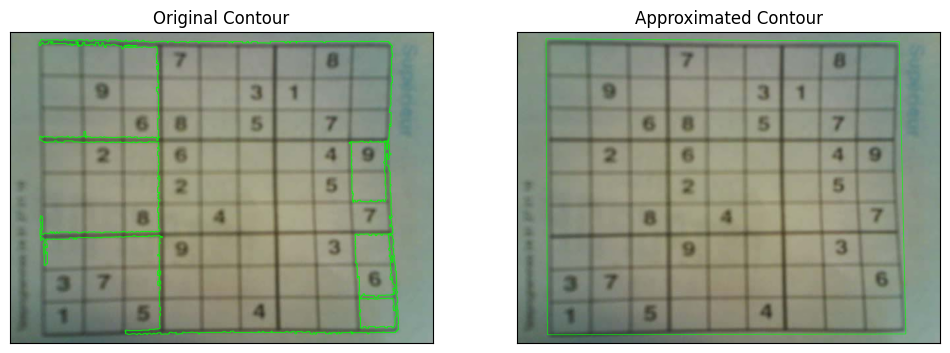

In [9]:
chosen_contour = img_options['chosen_contour']
perimeter = cv2.arcLength(contours[area_indices[chosen_contour]], True)*0.02
print(f"Perimeter: {perimeter}")
old_approx = cv2.approxPolyDP(contours[area_indices[chosen_contour]], epsilon=perimeter, closed=True)
approx = cv2.approxPolyN(contours[area_indices[chosen_contour]], nsides=4, epsilon_percentage=-1, ensure_convex=True)
print(f"Old approx: \n{old_approx}\nNew approx: \n{approx}")

# display results
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1),plt.imshow(results[chosen_contour + 1])
plt.title('Original Contour')
plt.xticks([]),plt.yticks([])
img_copy = copy(images[chosen_img])
approx_img = cv2.drawContours(img_copy, [approx], 0, (0,255,0), 3)
plt.subplot(1,2,2),plt.imshow(approx_img)
plt.title('Approximated Contour')
plt.xticks([]),plt.yticks([])
plt.show()

6.) Next we check that the approximation is only estimated using 4 points, that the area is above some threshold which should be tuned depending on the quality of the picture taken, and we check that the contour is convex as a rectangle would be. 

Printing these points also gives more insight into the type of result that approxPolyDP returns. Since we are concerned with 4 points, they are listed in a continuous fashion so that each point is connected by a line segment. Since we specified that the contours should be closed, the last point will connect back to the first point.

In [10]:
contourArea = cv2.contourArea(approx)
# if (len(approx) == 4 and abs(contourArea) > 2000 and cv2.isContourConvex(approx)):
# if (len(approx) == 4 and abs(contourArea) > 2000 and cv2.isContourConvex(approx)):
print(f"This is a valid contour; Area of contour is {contourArea}; Shape of approx is {approx.shape}")
for i in range(len(approx)):
    point = np.squeeze(approx[i])
    print(f"Point_{i}: ({point[0]},{point[1]})")

temp_approx = np.squeeze(approx)
print(f"temp_approx shape {temp_approx.shape}")
abs_vals = np.array([temp_approx[i,0]*temp_approx[i,1] for i in range(temp_approx.shape[0])])
tl_idx = np.argmin(abs_vals) # top left idx
br_idx = np.argmax(abs_vals) # bottom right idx
top_left = temp_approx[tl_idx, :] # top left pixel coordinates
bottom_right = temp_approx[br_idx, :] # bottom right pixel coordinates
other_idx = [i for i in range(len(temp_approx)) if (i!=tl_idx and i!=br_idx)] # remaining indices

# top right pixel coordinate will have a larger y pixel coordinate
top_right = temp_approx[other_idx[0],:] if temp_approx[other_idx[0],1] > temp_approx[other_idx[1],1] else temp_approx[other_idx[1],:]
# bottom left pixel coordinate will have a larger x pixel coordinate
bottom_left = temp_approx[other_idx[0],:] if temp_approx[other_idx[0],0] > temp_approx[other_idx[1],0] else temp_approx[other_idx[1],:]
# reorder_pts = order_points(temp_approx)

reordered_approx = np.array([top_left, top_right, bottom_right, bottom_left]).reshape(4, 1, 2)
# reordered_approx = np.array(reorder_pts).reshape(4, 1, 2)
print(f"Reordered: \n{reordered_approx}")
approx = reordered_approx

This is a valid contour; Area of contour is 6765090.0; Shape of approx is (1, 4, 2)
Point_0: ([3072   75],[3125 2427])
temp_approx shape (4, 2)
Reordered: 
[[[ 233   54]]

 [[ 244 2433]]

 [[3125 2427]]

 [[3072   75]]]


7.) This step will now perform a homography transformation so that we have a centered square that takes of most of the image of the sudoku puzzle. 

Orientation: landscape, Square Size: 2250, Image dimensions: (2500, 3400, 3)
Target (x,y) coordinates:
[[   0.    0.]
 [   0. 2250.]
 [2250. 2250.]
 [2250.    0.]]


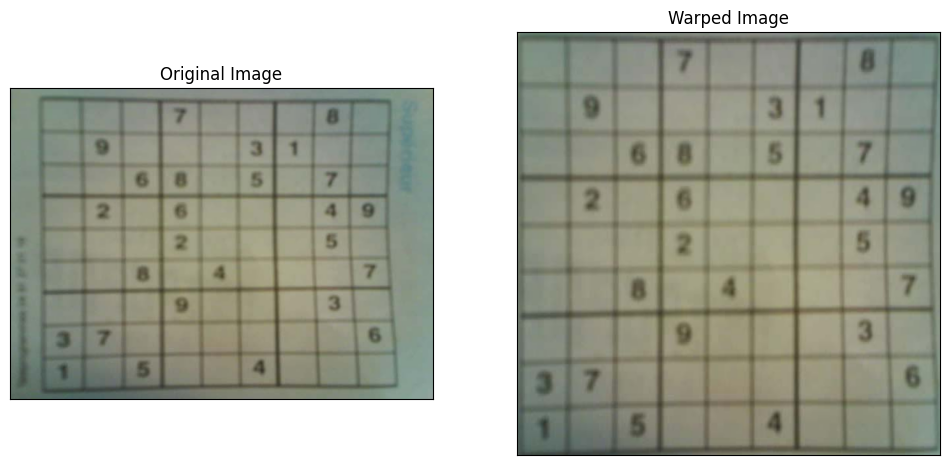

In [11]:
if images[chosen_img].shape[0] < images[chosen_img].shape[1]:
    orientation = 'landscape'
    square_size = int(images[chosen_img].shape[0] * 0.90)
else:
    orientation = 'portrait'
    square_size = int(images[chosen_img].shape[1] * 0.90)

# get the perspective transform matrix
# # order to use when using approxPolyDP
target_coordinates = np.array([[0, 0], [0, square_size], [square_size, square_size], [square_size, 0]], dtype=np.float32)
# order to use when using approxPolyN
# target_coordinates = np.array([[square_size, 0], [square_size, square_size], [0, square_size], [0, 0]], dtype=np.float32)
transformation_matrix = cv2.getPerspectiveTransform(approx.squeeze().astype(np.float32), target_coordinates)

# Apply the perspective transformation
result_img = cv2.warpPerspective(images[chosen_img], transformation_matrix, (int(square_size), int(square_size)))

print(f"Orientation: {orientation}, Square Size: {square_size}, Image dimensions: {images[chosen_img].shape}")
print(f"Target (x,y) coordinates:\n{target_coordinates}")

# display results
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1),plt.imshow(images[chosen_img],'gray')
plt.title('Original Image')
plt.xticks([]),plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_img,'gray')
plt.title('Warped Image')
plt.xticks([]),plt.yticks([])
plt.show()

7.5) TODO Step: Sometimes the warped image is a close but still not good enough warped transformation. Not good enough in the sense that if we were to evenly partition the image into a 9x9 grid, the number may be cut off.

To find the ideal split lines to form our 9x9 grid, the Hough transform may prove to be very useful at this step.

8.) Naive split of each cell

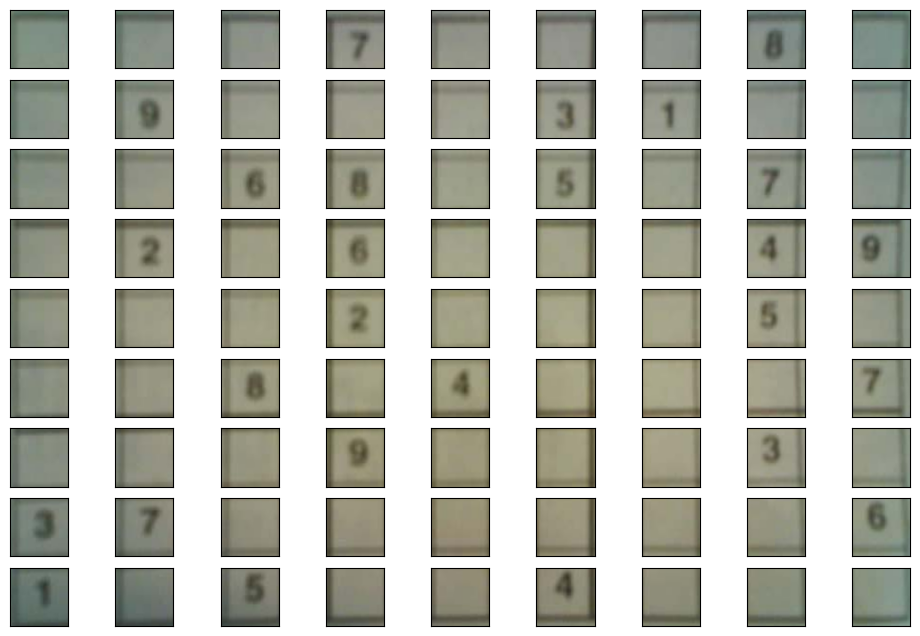

In [12]:
cells = []
step_x = result_img.shape[1] // 9
step_y = result_img.shape[0] // 9
for i in range(9):
    for j in range(9):
        curr_cell = copy(result_img[i*step_y: (i+1)*step_y, j*step_x: (j+1)*step_x, :])
        cells.append(curr_cell)

fig = plt.figure(figsize=(12,8))
for i in range(9**2):
    plt.subplot(9,9,i+1)
    plt.imshow(cells[i], 'gray')
    # plt.title('Blurred Image')
    plt.xticks([]),plt.yticks([])
plt.show()

Wrapping it all together into a single function except the naive split. 

In [13]:
def detectSudokuPuzzle(image_path: str, new_size: Optional[Tuple[int, int]] = None, silent: bool = True) -> cv2.Mat:
    """
    This performs all the above steps to pre-process an image containing a Sudoku puzzle. The final result
    should be a birds-eye view of the puzzle itself, with the puzzle taking up the entire new image.
    :param image_path:
    :param silent:
    :return:
    """
    original_image = resize_image_high_quality(cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB))
    colored_image = copy(original_image)
    gray_image = resize_image_high_quality(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))

    img_width = gray_image.shape[1]
    img_height = gray_image.shape[0]

    if not silent:
        print(f"Shape of image: {img_width}, {img_height}")
    modified_image = cv2.addWeighted(gray_image, 1.2, gray_image, 0, 0.0)
    modified_image = cv2.medianBlur(modified_image, 25)
    modified_image = cv2.adaptiveThreshold(modified_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    modified_image = cv2.Canny(modified_image, 250, 200)
    modified_image = cv2.dilate(modified_image, np.ones((11,11), np.uint8), np.zeros(gray_image.shape), [-1,1])

    contours, _ = cv2.findContours(modified_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # sort by the largest contour
    contour_areas = np.array([cv2.contourArea(cont) for cont in contours])
    area_indices = np.flip(np.argsort(contour_areas))

    # Just to analyze the area of the largest contour
    largest_area = contour_areas[area_indices[0]]
    total_area = img_width * img_height

    # filter out contours whose area is nearly the entire image
    # which would indicate that there is a border around the image
    l_i = 0
    area_threshold = 0.98
    for i, area_idx in enumerate(area_indices):
        curr_area = contour_areas[area_idx]
        if curr_area / total_area < area_threshold:
            l_i = i
            break
    area_indices = area_indices[l_i:]

    # for a_idx in area_indices:
    # perimeter = cv2.arcLength(contours[a_idx], True)*0.02
    approx = cv2.approxPolyN(contours[area_indices[0]], nsides=4, epsilon_percentage=-1.0, ensure_convex=True)

    contourArea = cv2.contourArea(approx)
    # if (len(approx) == 4 and abs(contourArea) > 2000 and cv2.isContourConvex(approx)):
    if not silent:
        print(f"This is a valid contour; Area of contour is {contourArea}; Shape of approx is {approx.shape}")
    for i in range(len(approx)):
        point = np.squeeze(approx[i])
        print(f"Point_{i}: ({point[0]},{point[1]})")

    temp_approx = np.squeeze(approx)
    if not silent:
        print(f"temp_approx shape {temp_approx.shape}")
    abs_vals = np.array([temp_approx[i,0]*temp_approx[i,1] for i in range(temp_approx.shape[0])])
    tl_idx = np.argmin(abs_vals)
    br_idx = np.argmax(abs_vals)
    top_left = temp_approx[tl_idx, :]
    bottom_right = temp_approx[br_idx, :]
    other_idx = [i for i in range(len(temp_approx)) if (i!=tl_idx and i!=br_idx)]
    top_right = temp_approx[other_idx[0],:] if temp_approx[other_idx[0],1] > temp_approx[other_idx[1],1] else temp_approx[other_idx[1],:]
    bottom_left = temp_approx[other_idx[0],:] if temp_approx[other_idx[0],0] > temp_approx[other_idx[1],0] else temp_approx[other_idx[1],:]

    reordered_approx = np.expand_dims(np.array([top_left, top_right, bottom_right, bottom_left]), axis=1)
    if not silent:
        print(f"Reordered: \n{reordered_approx}")
    approx = reordered_approx
    # break

    if img_height < img_width:
        orientation = 'landscape'
        square_size = int(img_height * 0.90)
    else:
        orientation = 'portrait'
        square_size = int(img_width * 0.90)

    # get the perspective transform matrix
    target_coordinates = np.array([[0, 0], [0, square_size], [square_size, square_size], [square_size, 0]], dtype=np.float32)
    transformation_matrix = cv2.getPerspectiveTransform(np.squeeze(approx).astype(np.float32), target_coordinates)

    # Apply the perspective transformation
    result_img = cv2.warpPerspective(colored_image, transformation_matrix, (int(square_size), int(square_size)))

    if not silent:
        print(f"Orientation: {orientation}, Square Size: {square_size}, Image dimensions: {original_image.shape}")
        print(f"Target (x,y) coordinates:\n{target_coordinates}")

    # display results
    fig = plt.figure(figsize=(12,8))
    plt.subplot(1,2,1),plt.imshow(colored_image,'gray')
    plt.title('Original Image')
    plt.xticks([]),plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(result_img,'gray')
    plt.title('Warped Image')
    plt.xticks([]),plt.yticks([])
    plt.show()

    if new_size is not None:
        result_img = cv2.resize(result_img, new_size)

    return result_img


Point_0: ([3072   75],[3125 2427])


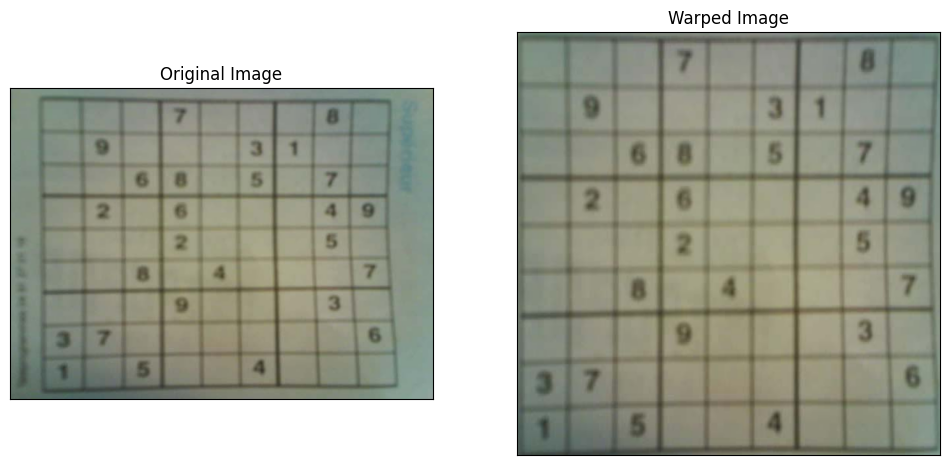

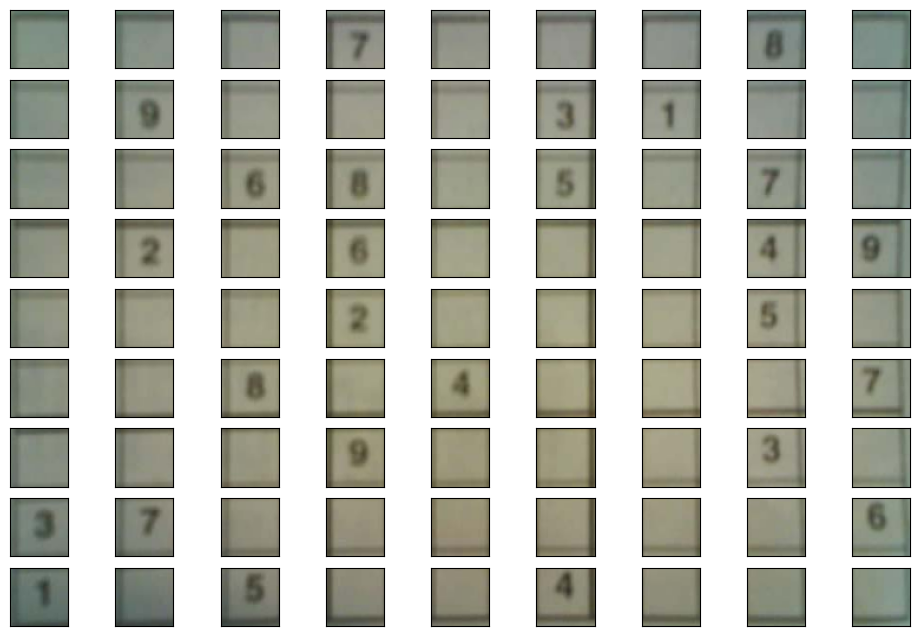

In [14]:
# test the function 
result = detectSudokuPuzzle(image_paths[3], new_size=(50*9, 50*9))

cells = []
step_x = result.shape[1] // 9
step_y = result.shape[0] // 9
for i in range(9):
    for j in range(9):
        curr_cell = copy(result[i*step_y: (i+1)*step_y, j*step_x: (j+1)*step_x, :])
        cells.append(curr_cell)

fig = plt.figure(figsize=(12,8))
for i in range(9**2):
    plt.subplot(9,9,i+1)
    plt.imshow(cells[i], 'gray')
    # plt.title('Blurred Image')
    plt.xticks([]),plt.yticks([])
plt.show()

# Classification
We employ a neural network (NN) classifer to detect the image in each cell. For more details into the architecture of the NN, refer to the **NumberModel.py** script.

In [15]:
import torch
from torch import nn
from python_scripts.NumberModel import NumberModel, to_numpy
device = torch.device("cuda")

In [16]:
def print_sudoku(grid: ndarray):
    print()
    for i in range(9):
        if i % 3 == 0 and i != 0:
            print("-" * 31)
        row = ""
        for j in range(9):
            if j % 3 == 0 and j != 0:
                row += "| "
            row += f"{grid[i][j]:2} "
        print(row)

In [17]:
# load in the model
pth_path = "models/TestNumberModelForTFLite.pth"
pth_dict = torch.load(pth_path, map_location=device)
# we don't train the model, so loss_fn and lrate can be any value
loss_fn = nn.CrossEntropyLoss()
lrate = 0.01
NetObject = NumberModel(lrate, loss_fn, 1, 10).to(device)
NetObject.load_state_dict(pth_dict["state_dict"])
NetObject.eval()

# let's transform our grid into a tensor of the appropriate size
cells_t = torch.tensor(cells, dtype=torch.float32).to(device)
rgb_weights = torch.tensor([0.299, 0.5870, 0.1140], dtype=torch.float32).to(device)
# convert the rgb image to grayscale
cells_bw_t = torch.einsum("bhwc,c->bhw", cells_t, rgb_weights) / 255.0
# add a channel dimension so that we have shape (bhw)->(bchw), channel dim. is 1 for black and white
cells_bw_t = cells_bw_t.unsqueeze(1)
print("Shape of cells_t: ", cells_bw_t.shape)

# output will have shape (81,)
output = to_numpy(NetObject(cells_bw_t).argmax(dim=1))
num_non_empty = np.count_nonzero(output)
print(f"Number of non-empty cells: {num_non_empty}")

# format the output to be 9x9
output = output.reshape(9, 9)
sudoku_grid = print_sudoku(output)

Shape of cells_t:  torch.Size([81, 1, 50, 50])
Number of non-empty cells: 26

 0  0  0 |  7  0  0 |  0  8  0 
 0  9  0 |  0  0  3 |  1  0  0 
 0  0  6 |  8  0  5 |  0  7  0 
-------------------------------
 0  2  0 |  6  0  0 |  0  4  9 
 0  0  0 |  2  0  0 |  0  5  0 
 0  0  8 |  0  4  0 |  0  0  7 
-------------------------------
 0  0  0 |  9  0  0 |  0  3  0 
 3  7  0 |  0  0  0 |  0  0  6 
 1  0  5 |  0  0  4 |  0  0  0 


/tmp/ipykernel_117332/4197388279.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  cells_t = torch.tensor(cells, dtype=torch.float32).to(device)
